In [23]:
import numpy as np
import pymc3 as pm
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde

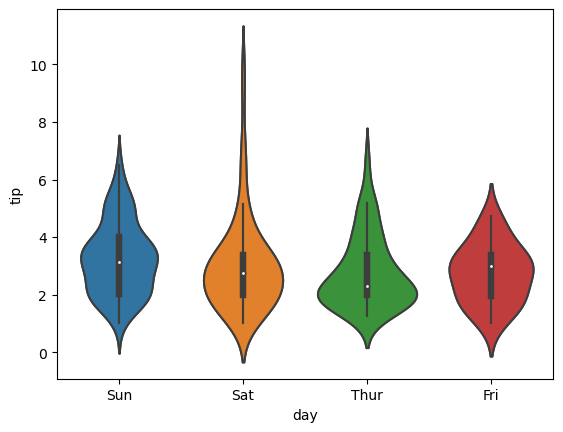

In [24]:
tips = pd.read_csv("C:/Users/Talha/Downloads/tips.csv")
tips.tail()
sns.violinplot(x='day', y='tip', data=tips)
sns.violinplot(x='day', y='tip', data=tips)
tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

C:\Users\Talha\anaconda3\envs\pm3bap\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 31 seconds.
C:\Users\Talha\anaconda3\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


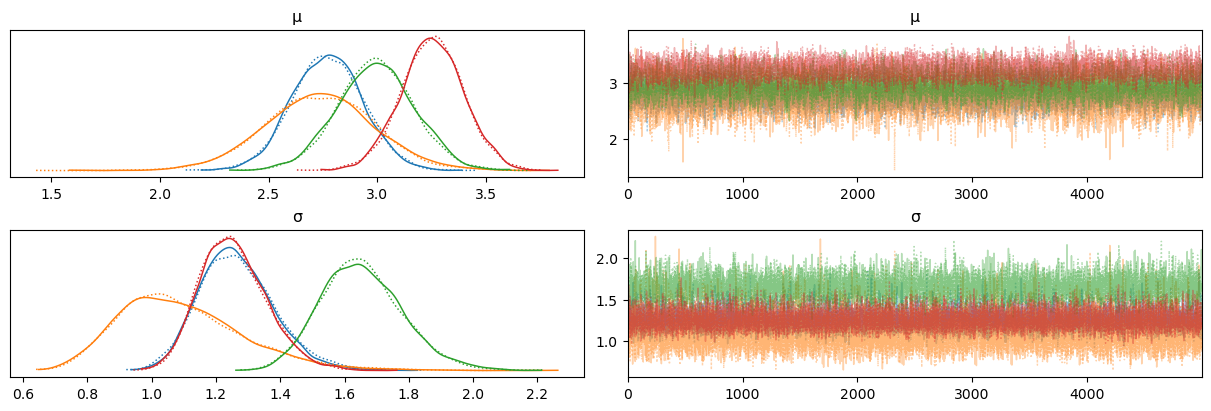

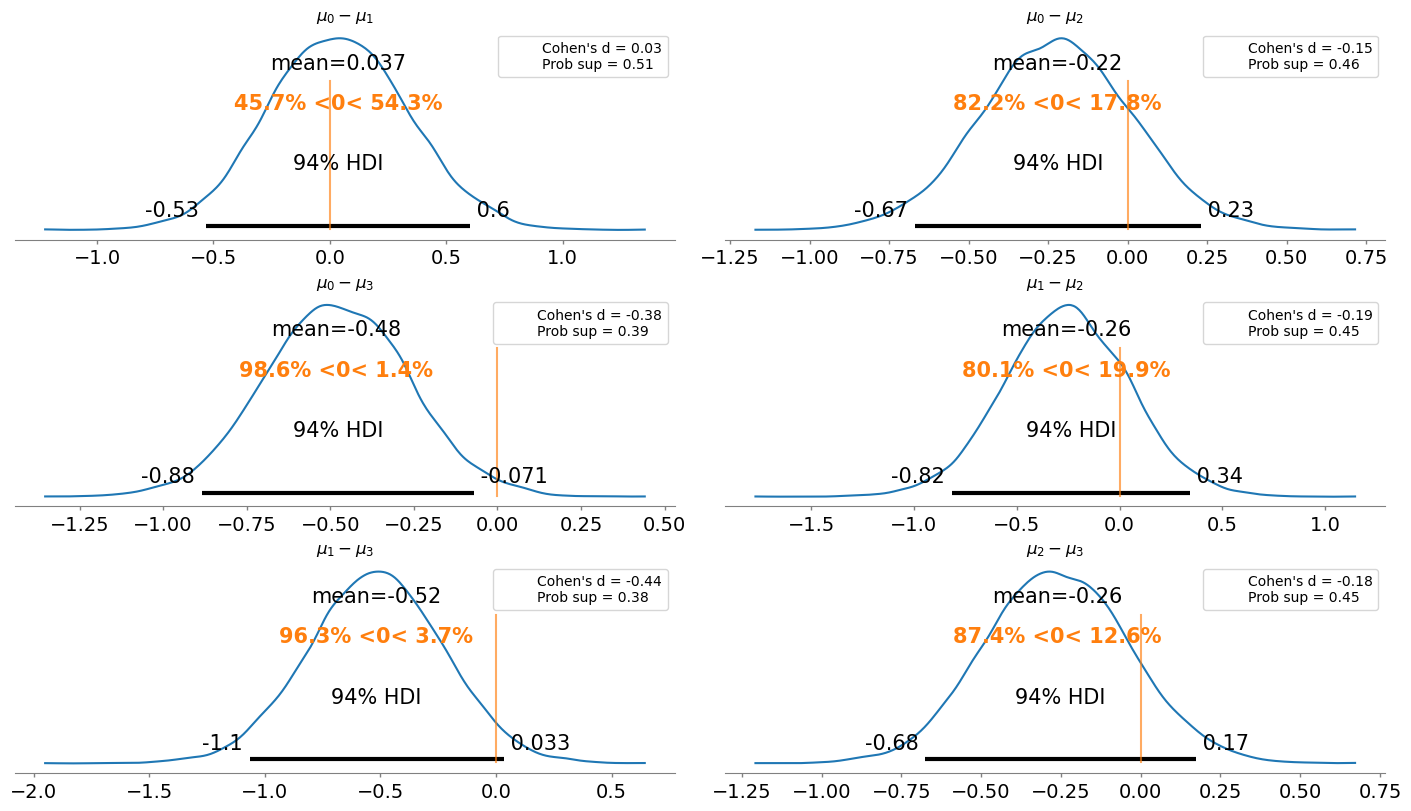

In [26]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)
comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]
for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}",alpha=0)
    ax[k, l].legend()



In [30]:
np.random.seed(42)
data_group_a=np.random.normal(5,1,100)
data_group_b=np.random.normal(5.1,1,100)
rope_lower, rope_upper = -0.1, 0.1
def calculate_kde(samples):
    kde = gaussian_kde(samples)
    return kde


In [31]:
with pm.Model() as model:
    mean_a = pm.Normal('mean_a', mu=5, sd=1)
    mean_b = pm.Normal('mean_b', mu=5.1, sd=1)
    sd_a = pm.HalfNormal('sd_a',sd=1)
    sd_b = pm.HalfNormal('sd_b',sd=1)
    obs_a = pm.Normal('obs_a',mu=mean_a,sd=sd_a,observed=data_group_a)
    obs_b = pm.Normal('obs_b',mu=mean_b,sd=sd_b,observed=data_group_b)
    diff_means = pm.Deterministic('diff_means',mean_b-mean_a)

C:\Users\Talha\anaconda3\envs\pm3bap\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_b, sd_a, mean_b, mean_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


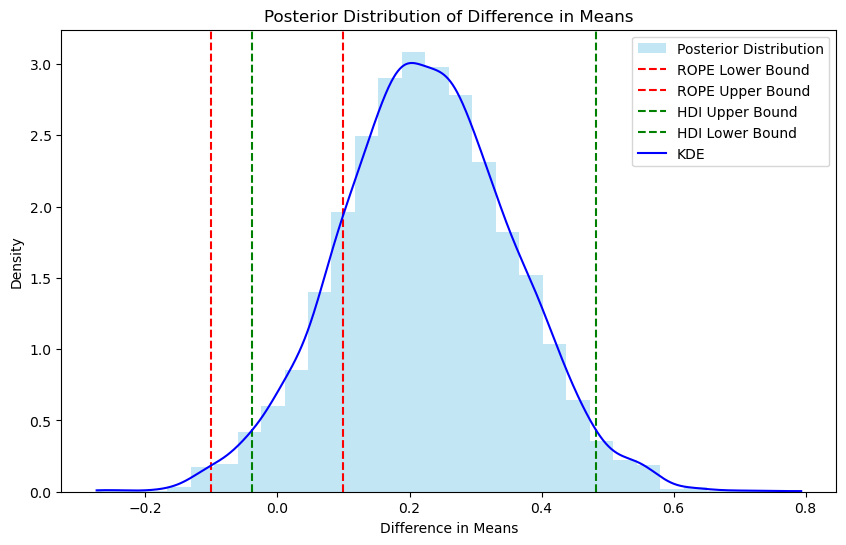

ROPE:  (-0.1, 0.1)
HDI Lower: -0.03897102601293903
HDI Upper: 0.4822128633919483


In [32]:
from arviz import hdi

with model:
    trace=pm.sample(2000,tune=1000,cores=1)
    posterior_samples = trace['diff_means']
    kde = calculate_kde(posterior_samples)
    plt.figure(figsize=(10, 6))
    plt.hist(posterior_samples, bins=30, density=True, alpha=0.5, color='skyblue', label='Posterior Distribution')
    x_vals = np.linspace(min(posterior_samples), max(posterior_samples), 1000)
    plt.axvline(x=rope_lower, color='r', linestyle='--', label='ROPE Lower Bound')
    plt.axvline(x=rope_upper, color='r', linestyle='--', label='ROPE Upper Bound')
    hdi_prob = 0.95
    lower_percentile = (1 - hdi_prob) / 2 * 100
    upper_percentile = 100 - lower_percentile
    hdi_lower = np.percentile(posterior_samples, lower_percentile)
    hdi_upper = np.percentile(posterior_samples, upper_percentile)
    plt.axvline(x=hdi_upper, color='g', linestyle='--', label='HDI Upper Bound')
    plt.axvline(x=hdi_lower, color='g', linestyle='--', label='HDI Lower Bound')
    x_vals=np.linspace(min(posterior_samples), max(posterior_samples),1000)
    plt.plot(x_vals, kde(x_vals),color='blue',label='KDE')
    plt.legend()
    plt.xlabel('Difference in Means')
    plt.ylabel('Density')
    plt.title('Posterior Distribution of Difference in Means')
    plt.show()
    print("ROPE: ",(rope_lower, rope_upper))
    print("HDI Lower:", hdi_lower)
    print("HDI Upper:", hdi_upper)